Import used libraries and load input data:
- Photoluminescence
- Photoreflection

In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

pl07wr_df = pd.read_csv('data/PL_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pl07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl07wr_df = pl07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)
                     
pl25_df = pd.read_csv('data/PL_NP7811_laser_2p5mW.txt', sep='\t')
pl25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl25_df = pl25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr07wr_df = pd.read_csv('data/PR_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pr07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr07wr_df = pr07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr25_df = pd.read_csv('data/PR_NP7811_laser_2p5mW.txt', sep='\t')
pr25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr25_df = pr25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)


Fitting function for photoreflectance

$
\displaystyle
y(x) = A + Bx + Cx^2 + \frac{D_1}{\left( (x - E_1)^2 + {G_1}^2 \right)^{\frac{n}{2}}} \cdot \cos\left( T_1 - n\left( \frac{\pi}{2} - \tan^{-1}\left( \frac{x - E_1}{G_1} \right) \right) \right)
$

In [2]:
def fit_pr1_generic(n):
    def fit_pr1(x, A, B, C, D1, T1, E1, G1):
        term1 = A + B * x + C * x**2
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        # angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1)) # standard function
        angle = np.abs(T1) - n * (np.pi / 2 - np.arctan((x - E1) / np.abs(G1))) # Basically emulates G1 >= 0 and T1 >= 0 without setting boundaries
        return term1 + (D1 / denom) * np.cos(angle)
    return fit_pr1

def fit_pr1_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
    }

def fit_pr1_reduced_generic(n):
    def fit_pr1_reduced(x, D1, T1, E1, G1):
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        # angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1))  # standard function
        angle = np.abs(T1) - n * (np.pi / 2 - np.arctan((x - E1) / np.abs(G1))) # Basically emulates G1 >= 0 and T1 >= 0 without setting boundaries
        return (D1 / denom) * np.cos(angle)
    return fit_pr1_reduced

def fit_pr2_generic(n):
    def fit_pr2(x, A1, B1, C1, D1, T1, E1, G1, D2, T2, E2, G2):
        fit1 = fit_pr1_generic(n)(x, A1, B1, C1, D1, T1, E1, G1)
        fit2 = fit_pr1_reduced_generic(n)(x, D2, T2, E2, G2)
        return fit1 + fit2
    return fit_pr2

def fit_pr2_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
        'D2': params[7],
        'T2': params[8],
        'E2': params[9],
        'G2': params[10],
    }

Fitting function for module

$
\displaystyle
\frac{|\!D\!|}{\left( (x - E)^2 + G^2 \right)^{\frac{n}{2}}}
$

In [3]:
def fit_module_generic(n):
    def fit_module(x, D, E, G):
        denom = ((x - E)**2 + G**2)**(n / 2)
        return np.abs(D)/denom
    return fit_module

def fit_module1_calc(n, x, params_dict):
    D = params_dict['D1']
    E = params_dict['E1']
    G = params_dict['G1']
    return fit_module_generic(n)(x, D, E, G)

def fit_module2_calc(n, x, params_dict):
    D1 = params_dict['D1']
    E1 = params_dict['E1']
    G1 = params_dict['G1']
    fit1 = fit_module_generic(n)(x, D1, E1, G1)
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit1 + fit2

def fit_module12_calc(n, x, params_dict):
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit2

def fit_moduleN_calc(n, x, sd, params_dict):
    if sd == 1:
        return fit_module1_calc(n, x, params_dict)
    elif sd == 2:
        return fit_module2_calc(n, x, params_dict)
    else:
        raise Exception("Not supported")
        

Print all dataset to confirm everything is fine

In [4]:
print(f'Photoluminescence 0.7mW laser (wide-range): \n {pl07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')
print(f'Photoreflection 0.7mW laser: \n {pr07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')

Photoluminescence 0.7mW laser (wide-range): 
       energy          AC_X          AC_Y          AC_R      DC_R
0     1.0995 -2.185517e-07 -3.178930e-07  2.980247e-07  0.011333
1     1.1000 -4.371030e-07 -3.774987e-07  5.165773e-07  0.010222
2     1.1005 -1.351043e-06  8.742060e-07  1.589463e-06  0.011000
3     1.1010 -1.370910e-06  2.980250e-07  1.370913e-06  0.011000
4     1.1015 -7.748640e-07 -1.152363e-06  1.291440e-06  0.012444
...      ...           ...           ...           ...       ...
1196  1.6975 -7.351290e-07 -7.549957e-07  1.013288e-06  0.010444
1197  1.6980 -1.986830e-07 -3.178933e-07  3.377613e-07  0.010889
1198  1.6985  1.390783e-07 -1.152363e-06  1.092763e-06  0.010111
1199  1.6990 -5.761813e-07 -8.146017e-07  9.338137e-07  0.012444
1200  1.6995 -7.748640e-07 -1.668937e-06  1.768280e-06  0.013556

[1201 rows x 5 columns]
Photoluminescence 2.5mW laser: 
      energy          AC_X      AC_Y      AC_R      DC_R
0     1.099 -1.270330e-05  0.000082 -0.000084  0.020556
1   

In [5]:
from dataclasses import dataclass

@dataclass
class Result:
    # Name of result set
    name: str
    # Color used on charts
    color: str
    # Related energy range 
    energy_start: float
    energy_stop: float
    energy_idx_start: int
    energy_idx_stop: int
    # Single/Double fit
    sd: int
    # PR fit n
    n: int
    # Params fitted from PR
    fitted_params: {}
    covariance: [float]
    y_fitted: [float]
    x_fit: [float]

global_results_wr = {}
global_results_nr = {}

# Plotting

## Photoluminescence
Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

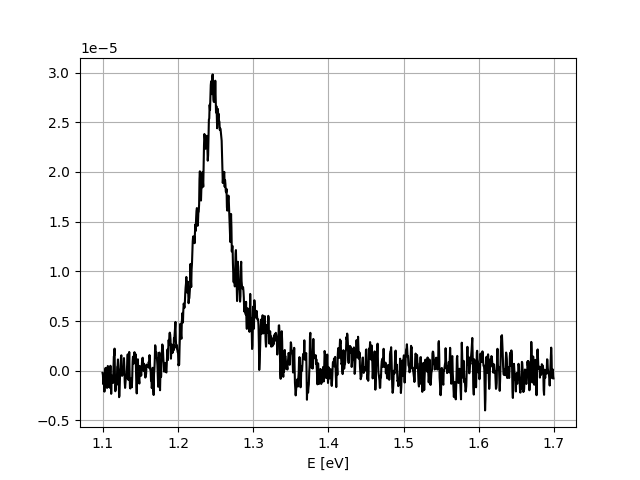

In [6]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']

plt.figure()
plt.plot(energy_wr, pl_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## Photoluminescence
Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

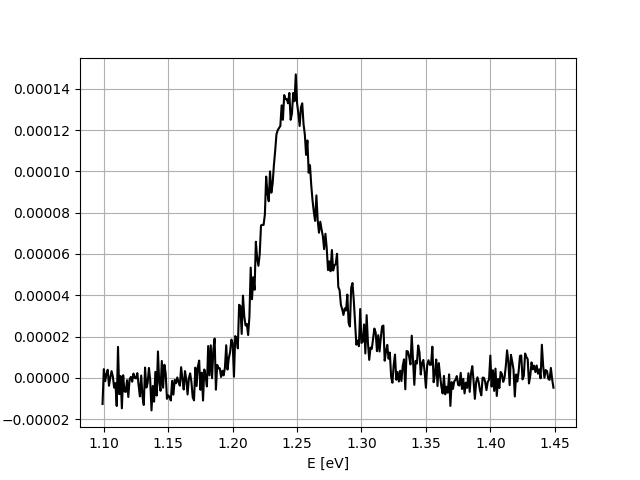

In [7]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']

plt.figure()
plt.plot(energy, pl, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Photoreflectance

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

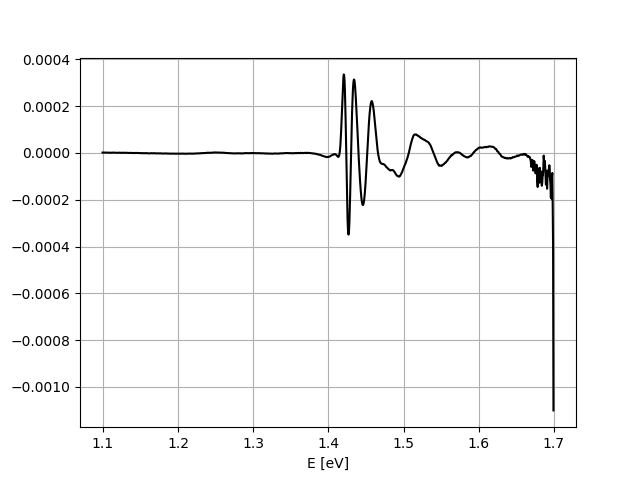

In [8]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']
pr_wr = pr07wr_df['AC_X']
r_wr = pr07wr_df['DC_R']
y_wr = (pr_wr-pl_wr)/r_wr

plt.figure()
plt.plot(energy_wr, y_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## I transition
Here I will try to fit function to first transition. \
Teacher advised me to use doubled fit function for the first transition.

Fitting from 1.415 eV to 1.4400507 eV, idx: 631, 681
Params [ 9.47062599e-01 -1.30965725e+00  4.52649610e-01  1.03992444e-09
  5.44099898e+00  1.42298232e+00 -1.01186834e-02  2.82704472e-09
  3.39788630e+00  1.42841584e+00 -1.40757011e-02]
 Covariance: [[ 5.00727894e-01 -7.00943685e-01  2.45283513e-01  6.32919263e-11
   1.32650255e-01  1.82040619e-04 -4.57192051e-05  4.17426518e-10
   1.24021499e-01  6.40454485e-05 -5.07029737e-04]
 [-7.00943685e-01  9.81217360e-01 -3.43361191e-01 -8.84582524e-11
  -1.85716563e-01 -2.54824972e-04  6.38087131e-05 -5.84062862e-10
  -1.73718207e-01 -9.00813293e-05  7.09734534e-04]
 [ 2.45283513e-01 -3.43361191e-01  1.20153920e-01  3.09052187e-11
   6.49974649e-02  8.91700347e-05 -2.22619463e-05  2.04287975e-10
   6.08270601e-02  3.16718638e-05 -2.48348714e-04]
 [ 6.32919263e-11 -8.84582524e-11  3.09052187e-11  2.06291701e-20
   1.46083516e-11  2.38582777e-14 -2.30783292e-14  7.61656888e-20
   6.33982737e-12 -2.94564832e-14 -6.58822162e-14]
 [ 1.32650255e-

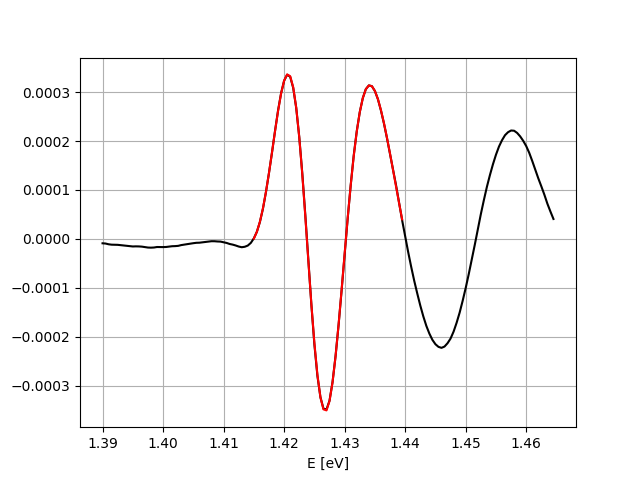

In [9]:
# Fitting range for the first transition
start_energy, stop_energy = 1.4150, 1.4400507

# Fitting params
n = 3
"""
# parameters for standard function (negative results)
params1 = [
    1.30246864e+00,  #A1
    -1.80140004e+00, #B1 
    6.22648896e-01,  #C1
    7.56386049e-08,  #D1
    -3.57483951e+00, #T1 
    1.42247817e+00,  #E1
    -8.05044852e-03  #G1
]
params2 = [
    1.47047956e-07,  #D2
    -1.74818495e+00, #T2
    1.42897126e+00,  #E2
    -1.05916087e-02  #G2
]
"""

# parameters for function with np.mod(G1) np.mod(T1)
params1 = [
    1.30246864e+00,  #A1
    -1.80140004e+00, #B1 
    6.22648896e-01,  #C1
    -1.04e-09,  #D1
    3.57483951e+00, #T1 
    1.42247817e+00,  #E1
    -8.05044852e-03  #G1
]
params2 = [
    3e-9,  #D2
    1.74818495e+00, #T2
    1.42897126e+00,  #E2
    -1.05916087e-02  #G2
]

# Double function used
fit_pr = fit_pr2_generic(n)

# Both-sided context
margin_idx = 50

start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1 + params2
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ff0000')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()
    
global_results_wr['T1'] = Result(
    name = 'PR WR I transition',
    color = '#ff0000',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 2,
    n = n,
    fitted_params = fit_pr2_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## II transition

[1.30246864, -1.80140004, 0.622648896, -1.04e-09, 3.57483951, 1.42247817, -0.00805044852, 3e-09, 1.74818495, 1.42897126, -0.0105916087]
Fitting from 1.4400507 eV to 1.466 eV, idx: 681, 733
Params [ 2.52554982e+00 -3.45714165e+00  1.18297971e+00  3.26048834e-09
 -3.57346970e+00  1.45278367e+00  1.83555278e-02]
 Covariance: [[ 1.49340622e-02 -2.05617470e-02  7.07693921e-03  7.14827599e-12
  -4.86048310e-03  1.66284669e-05  7.48118605e-06]
 [-2.05617470e-02  2.83102057e-02 -9.74382409e-03 -9.83047004e-12
   6.69372668e-03 -2.29012375e-05 -1.02861218e-05]
 [ 7.07693921e-03 -9.74382409e-03  3.35364278e-03  3.37947921e-12
  -2.30440876e-03  7.88439792e-06  3.53537121e-06]
 [ 7.14827599e-12 -9.83047004e-12  3.37947921e-12  5.65972557e-21
  -2.05881505e-12  6.91304579e-15  6.38910181e-15]
 [-4.86048310e-03  6.69372668e-03 -2.30440876e-03 -2.05881505e-12
   1.65326759e-03 -5.72481358e-06 -2.11151285e-06]
 [ 1.66284669e-05 -2.29012375e-05  7.88439792e-06  6.91304579e-15
  -5.72481358e-06  1.9915

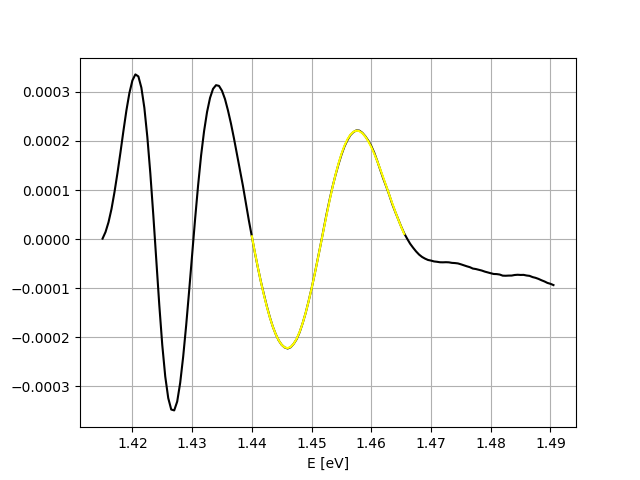

In [10]:
# Fitting range for the second transition
start_energy, stop_energy = 1.4400507, 1.466

# Fitting params
n = 3
"""
# parameters for standard function (negative results)
params1 = [
    7.79067537e-01,  #A1
    -1.03719700e+00, #B1
    3.44798239e-01,  #C1
    1.72295879e-07,  #D1
    1.48424046e+00,  #T1
    1.45111328e+00,  #E1
    1.52253710e-02   #G1
]
"""

# parameters for function with np.mod(G1) np.mod(T1)
params1 = [
    7.79067537e-01,  #A1
    -1.03719700e+00, #B1
    3.44798239e-01,  #C1
    3.26e-09,  #D1
    -1.48424046e+00,  #T1
    1.45111328e+00,  #E1
    1.52253710e-02   #G1
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ffff00')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T2'] = Result(
    name = 'PR WR II transition',
    color = '#ffff00',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## III transition

[0.779067537, -1.037197, 0.344798239, 3.26e-09, -1.48424046, 1.45111328, 0.015225371]
Fitting from 1.466 eV to 1.541 eV, idx: 733, 883
Params [ 1.18530226e-02 -1.59629550e-02  5.36643882e-03  3.54229688e-09
  9.61756988e+00  1.50717922e+00  3.10693532e-02]
 Covariance: [[ 1.85253709e-04 -2.46859542e-04  8.22085002e-05 -1.20763997e-12
   1.68537216e-03  1.22339977e-05 -2.89116294e-06]
 [-2.46859542e-04  3.28958451e-04 -1.09550906e-04  1.62748680e-12
  -2.24538593e-03 -1.62972489e-05  3.89573558e-06]
 [ 8.22085002e-05 -1.09550906e-04  3.64837116e-05 -5.48057139e-13
   7.47589932e-04  5.42544347e-06 -1.31170196e-06]
 [-1.20763997e-12  1.62748680e-12 -5.48057139e-13  7.09005265e-20
  -9.62859157e-12 -6.42004745e-14  1.73244312e-13]
 [ 1.68537216e-03 -2.24538593e-03  7.47589932e-04 -9.62859157e-12
   1.69911357e-02  1.27787459e-04 -2.34554705e-05]
 [ 1.22339977e-05 -1.62972489e-05  5.42544347e-06 -6.42004745e-14
   1.27787459e-04  9.84798956e-07 -1.57545191e-07]
 [-2.89116294e-06  3.8957355

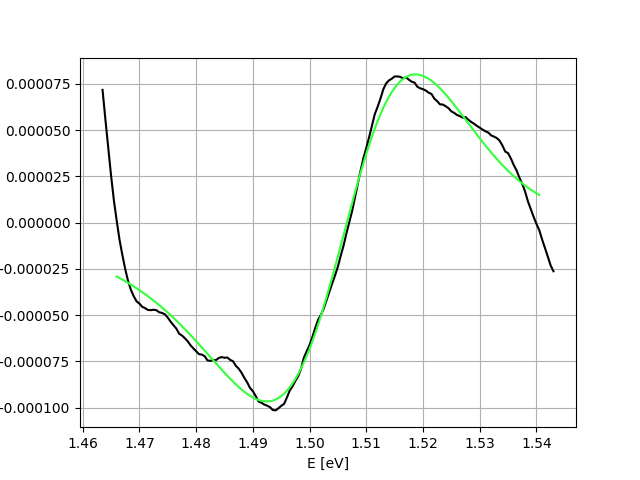

In [11]:
# Fitting range for the third transition
start_energy, stop_energy = 1.466, 1.541

# Fitting params
n = 3
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [
0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 5

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=100000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#33ff3a')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T3'] = Result(
    name = 'PR WR III transition',
    color = '#33ff3a',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## VI transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.541 eV to 1.5928 eV, idx: 883, 987
Params [ 1.12404119e+00 -1.43236493e+00  4.56144455e-01  9.32369272e-08
  1.06559265e+01  1.56524436e+00 -6.00915161e-02]
 Covariance: [[ 2.44432192e-02 -3.11938870e-02  9.94625029e-03  6.06861001e-09
   1.25114364e-02  1.07011717e-04 -6.32383463e-04]
 [-3.11938870e-02  3.98092427e-02 -1.26933756e-02 -7.74364943e-09
  -1.60210387e-02 -1.37184353e-04  8.06926432e-04]
 [ 9.94625029e-03 -1.26933756e-02  4.04737703e-03  2.46876928e-09
   5.12560148e-03  4.39383277e-05 -2.57256010e-04]
 [ 6.06861001e-09 -7.74364943e-09  2.46876928e-09  1.51459211e-15
   2.94320494e-09  2.47182196e-11 -1.58060470e-10]
 [ 1.25114364e-02 -1.60210387e-02  5.12560148e-03  2.94320494e-09
   1.60934574e-02  1.65510517e-04 -3.06128547e-04]
 [ 1.07011717e-04 -1.37184353e-04  4.39383277e-05  2.47182196e-11
   1.65510517e-04  1.73540551e-06 -2.56962684e-06]
 [-6.32383463e-04  8.06926432e-04 -2.57256010e-04 -1.58060470e-10
  -3.061

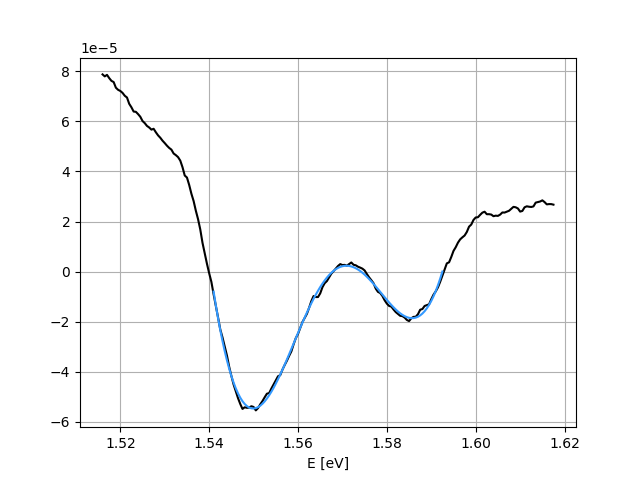

In [12]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.541, 1.5928

# Fitting params
n = 3
params1 = [
0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#3399ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T4'] = Result(
    name = 'PR WR IV transition',
    color = '#3399ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## V transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.5928 eV to 1.6617 eV, idx: 987, 1124
[-3.13967238e-02  3.86282988e-02 -1.18772407e-02  1.17799274e-09
  6.89245650e+00  1.63040614e+00 -3.14336370e-02]


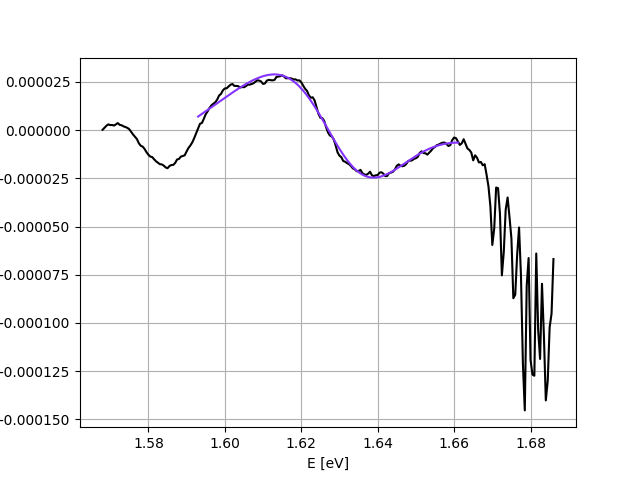

In [13]:
# Fitting range for the fifth transition
start_energy, stop_energy = 1.5928, 1.6617

# Fitting params
n = 3
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
y_fitted = fit_pr(x_fit, *params_final)

print(params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#8533ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T5'] = Result(
    name = 'PR WR V transition',
    color = '#8533ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

# All Transition 

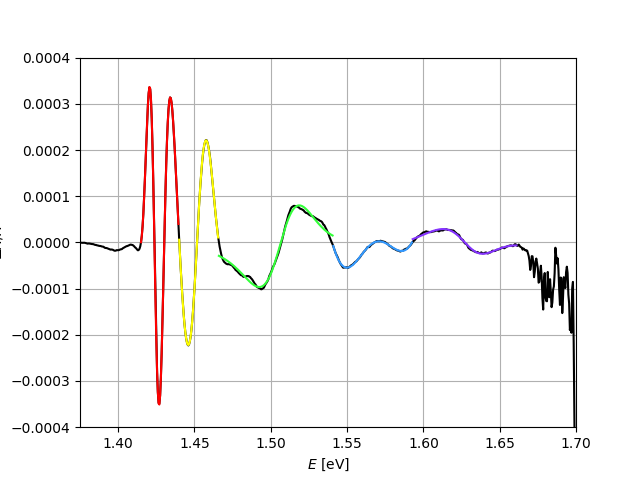

In [14]:
plt.figure()
# Plot base
plt.plot(energy_wr, y_wr, color='black')
# Apply results
for r in global_results_wr.values():
    plt.plot(r.x_fit, r.y_fitted, color=r.color)
plt.xlabel(r'$E $ [eV]')
plt.ylabel(r'$\Delta R / R$')
plt.ylim(-0.0004, 0.0004)
plt.xlim(1.375, 1.7)
plt.grid(True)
plt.show()


# Photoreflectance

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

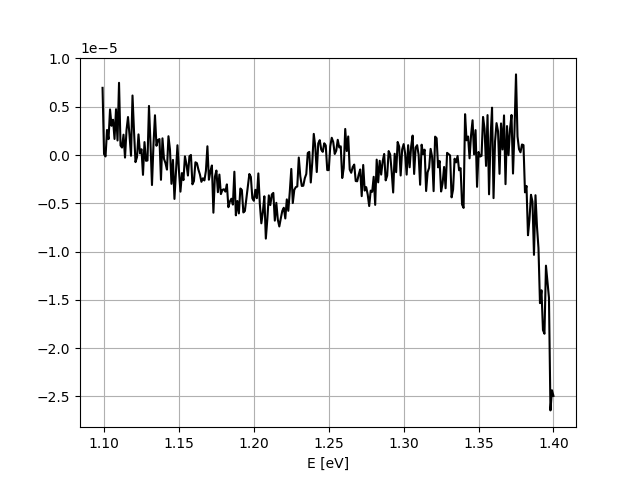

In [15]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']
pr = pr25_df['AC_X']
r = pr25_df['DC_R']
y_nr = (pr-pl)/r

plt.figure()
plt.plot(energy, y_nr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## I Transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.13 eV to 1.28 eV, idx: 31, 181
Params [ 5.41282512e-04 -8.67088948e-04  3.44416083e-04  6.13199254e-10
  1.06883160e+01  1.24692101e+00  4.79794603e-02]
 Covariance: [[ 1.21301499e-07 -2.04611070e-07  8.61487561e-08 -9.32271356e-14
   9.78609889e-05  8.24300139e-07 -1.98933267e-06]
 [-2.04611070e-07  3.45182545e-07 -1.45353482e-07  1.58384012e-13
  -1.64287252e-04 -1.37601541e-06  3.37813339e-06]
 [ 8.61487561e-08 -1.45353482e-07  6.12151420e-08 -6.71636558e-14
   6.88239828e-05  5.73026632e-07 -1.43183558e-06]
 [-9.32271356e-14  1.58384012e-13 -6.71636558e-14  1.08250508e-19
  -5.39433574e-11 -2.39941749e-13  2.30909570e-12]
 [ 9.78609889e-05 -1.64287252e-04  6.88239828e-05 -5.39433574e-11
   1.40613497e-01  1.65806478e-03 -1.26233406e-03]
 [ 8.24300139e-07 -1.37601541e-06  5.73026632e-07 -2.39941749e-13
   1.65806478e-03  2.25574541e-05 -6.84458846e-06]
 [-1.98933267e-06  3.37813339e-06 -1.43183558e-06  2.30909570e-12
  -1.2623340

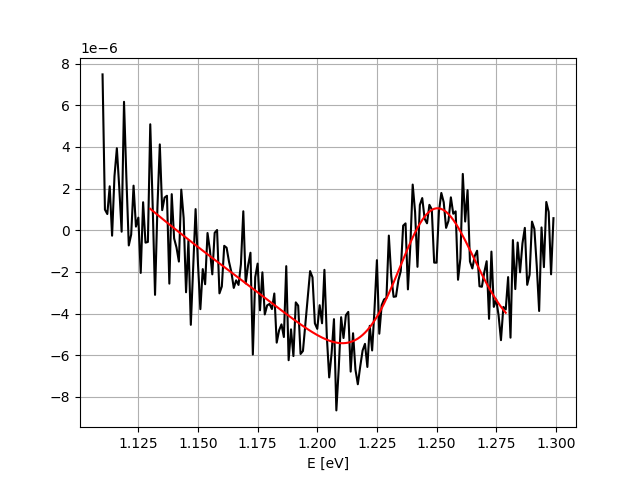

In [16]:
# Fitting range for the first transition
start_energy, stop_energy = 1.13, 1.28

# Fitting params
n = 3
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 20

print(initial_guess)
start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy[start_idx:stop_idx], y_nr[start_idx:stop_idx]
x_contex = energy[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_nr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ff0000')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_nr['T1'] = Result(
    name = 'PR NR I transition',
    color = '#ff0000',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## II Transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.275 eV to 1.36 eV, idx: 176, 261
Params [-3.99788217e-03  6.01263827e-03 -2.25943162e-03  3.57265593e-10
 -8.35374528e+00  1.33490076e+00 -4.46882749e-02]
 Covariance: [[ 4.28558823e-05 -6.56859291e-05  2.51516775e-05 -4.14755968e-12
   2.19537968e-02 -2.19910698e-04  7.14254256e-05]
 [-6.56859291e-05  1.00680953e-04 -3.85527207e-05  6.33482198e-12
  -3.37163277e-02  3.37670657e-04 -1.08690910e-04]
 [ 2.51516775e-05 -3.85527207e-05  1.47630433e-05 -2.41704179e-12
   1.29360373e-02 -1.29529396e-04  4.13147873e-05]
 [-4.14755968e-12  6.33482198e-12 -2.41704179e-12  6.30801330e-19
  -1.69724752e-09  1.79827676e-11 -1.49531766e-11]
 [ 2.19537968e-02 -3.37163277e-02  1.29360373e-02 -1.69724752e-09
   1.29781742e+01 -1.29899447e-01  2.10829077e-02]
 [-2.19910698e-04  3.37670657e-04 -1.29529396e-04  1.79827676e-11
  -1.29899447e-01  1.31241333e-03 -2.43551711e-04]
 [ 7.14254256e-05 -1.08690910e-04  4.13147873e-05 -1.49531766e-11
   2.10829

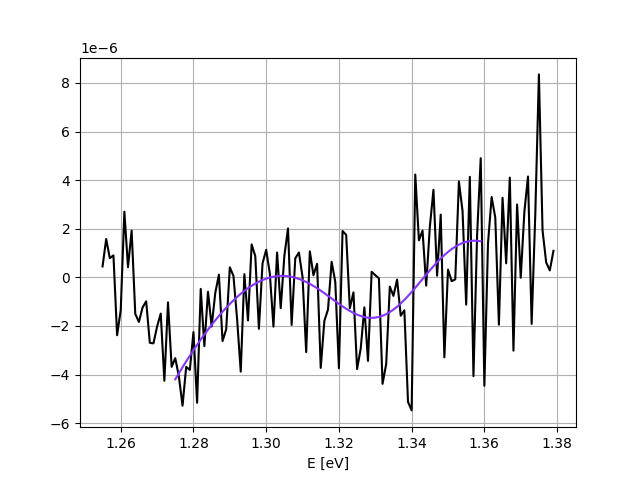

In [17]:
# Fitting range for the first transition
start_energy, stop_energy = 1.275, 1.36

# Fitting params
n = 3
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 20

print(initial_guess)
start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy[start_idx:stop_idx], y_nr[start_idx:stop_idx]
x_contex = energy[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_nr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#8533ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_nr['T2'] = Result(
    name = 'PR NR II transition',
    color = '#8533ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## All transitions

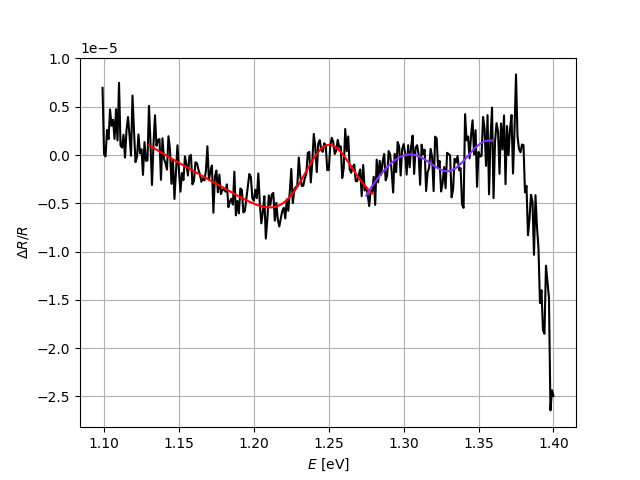

In [18]:
plt.figure()
# Plot base
plt.plot(energy, y_nr, color='black')
# Apply results
for r in global_results_nr.values():
    plt.plot(r.x_fit, r.y_fitted, color=r.color)
plt.xlabel(r'$E $ [eV]')
plt.ylabel(r'$\Delta R / R$')
plt.grid(True)
plt.show()

# Module

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

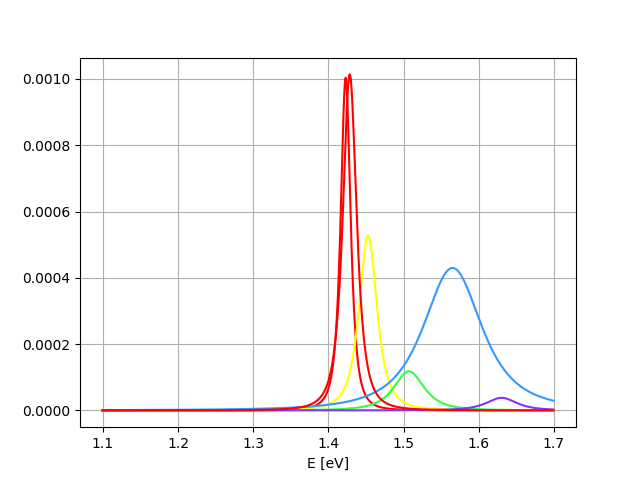

In [19]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.15, 1.35

energy_wr = pl07wr_df['energy']
ac_x_wr = pl07wr_df['AC_X']
ac_y_wr = pl07wr_df['AC_Y']
r_wr = pl07wr_df['AC_R']
r_calc_wr = np.sqrt((ac_x_wr**2)+(ac_y_wr**2))

plt.figure()
# plt.plot(energy_wr, r_wr, color='black')
for r in global_results_wr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    plt.plot(energy_wr, y, color=r.color)
    
r = global_results_wr['T1']
y = fit_module12_calc(r.n, energy_wr, r.fitted_params)
plt.plot(energy_wr, y, color=r.color)

plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Module

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

# Final output

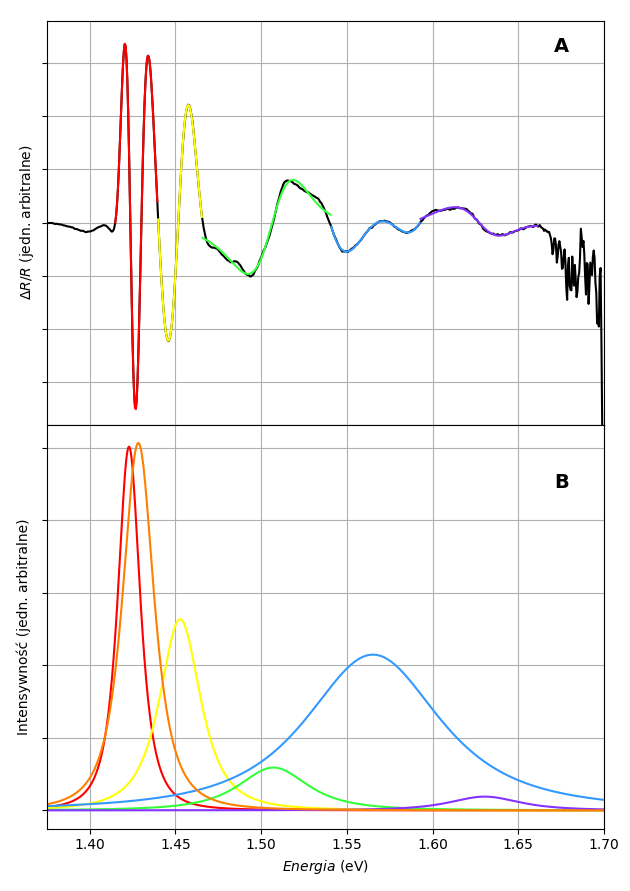

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(2.1*3, 2.97*3), dpi=100)
plt.xlabel(r'$Energia $ (eV)')
plt.tight_layout()

# Remove vertical space
fig.subplots_adjust(hspace=0)

# Plot base
axs[0].grid(True)
axs[0].tick_params(axis='y', labelleft=False)
axs[0].set_ylabel(r'$\Delta R / R$ (jedn. arbitralne)')
axs[0].plot(energy_wr, y_wr, color='black')
axs[0].set_ylim(-0.00038, 0.00038)
axs[0].text(0.91, 0.96, 'A', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Apply PR fit results
for r in global_results_wr.values():
    axs[0].plot(r.x_fit, r.y_fitted, color=r.color)

axs[1].set_ylabel(r'Intensywność (jedn. arbitralne)')
for r in global_results_wr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    axs[1].plot(energy_wr, y, color=r.color)

# Orange peak
r = global_results_wr['T1']
op = fit_module12_calc(r.n, energy_wr, r.fitted_params)
axs[1].plot(energy_wr, op, color='#ff8000')

axs[1].text(0.91, 0.88, 'B', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlim(1.375, 1.7)
plt.grid(True)
plt.show()


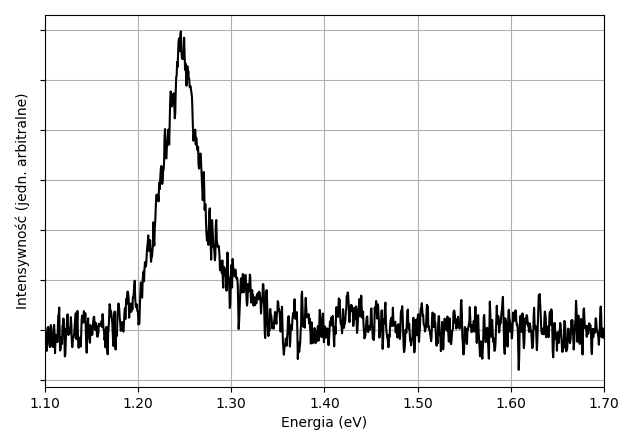

In [21]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']

plt.figure(figsize=(2.1*3, 2.97*1.5),dpi=100)
plt.plot(energy_wr, pl_wr, color='black')
plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlabel('Energia (eV)')
plt.ylabel('Intensywność (jedn. arbitralne)')
plt.grid(True)
plt.xlim(1.10, 1.70)
plt.tight_layout()

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

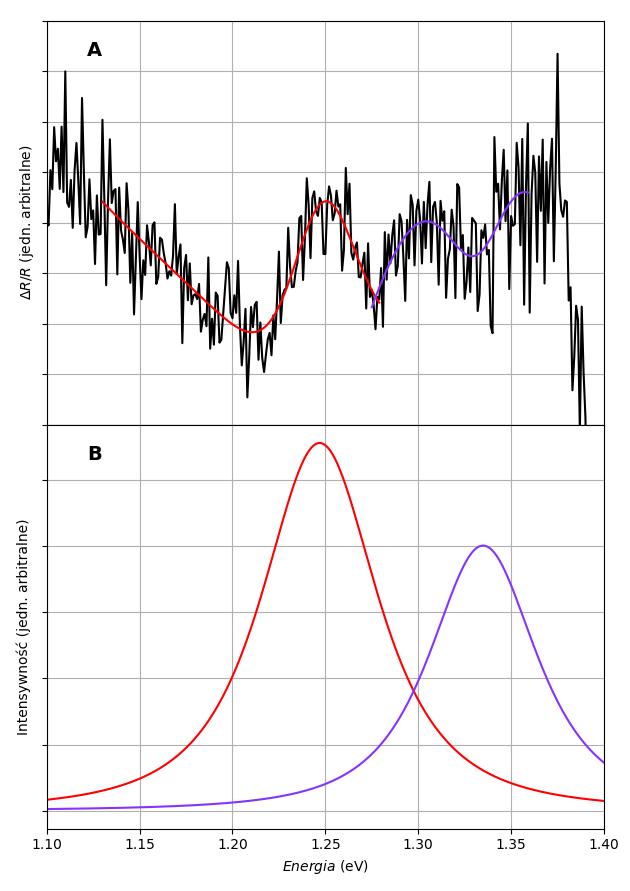

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(2.1*3, 2.97*3), dpi=100)
plt.xlabel(r'$Energia $ (eV)')
plt.tight_layout()

# Remove vertical space
fig.subplots_adjust(hspace=0)

# Plot base
axs[0].grid(True)
axs[0].tick_params(axis='y', labelleft=False)
axs[0].set_ylabel(r'$\Delta R / R$ (jedn. arbitralne)')
axs[0].plot(energy, y_nr, color='black')
axs[0].set_ylim(-1e-5, 1e-5)
axs[0].text(0.073, 0.95, 'A', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Apply PR fit results
for r in global_results_nr.values():
    axs[0].plot(r.x_fit, r.y_fitted, color=r.color)

axs[1].set_ylabel(r'Intensywność (jedn. arbitralne)')
for r in global_results_nr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    axs[1].plot(energy_wr, y, color=r.color)

axs[1].text(0.073, 0.95, 'B', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlim(1.1, 1.4)
plt.grid(True)
plt.show()

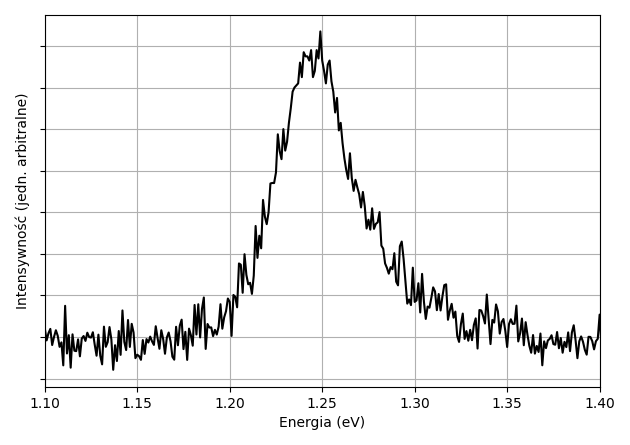

In [23]:
energy_wr = pl25_df['energy']
pl_wr = pl25_df['AC_X']

plt.figure(figsize=(2.1*3, 2.97*1.5),dpi=100)
plt.plot(energy_wr, pl_wr, color='black')
plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlabel('Energia (eV)')
plt.ylabel('Intensywność (jedn. arbitralne)')
plt.grid(True)
plt.xlim(1.1, 1.4)
plt.tight_layout()
plt.show()

In [24]:
for r in global_results_wr.values():
    print(f'Name: {r.name}')
    perr = np.sqrt(np.diag(r.covariance))
    for i, (k, v) in enumerate(r.fitted_params.items()):
        u = perr[i]
        print(f'{k}: {v} \nu({k}): {u}')
    print('\n')


Name: PR WR I transition
A1: 0.9470625986187057 
u(A1): 0.7076212928689888
B1: -1.3096572501571127 
u(B1): 0.9905641625166334
C1: 0.4526496104595236 
u(C1): 0.34663225413661863
D1: 1.0399244396508287e-09 
u(D1): 1.436285839760512e-10
T1: 5.440998976825577 
u(T1): 0.19704604314880292
E1: 1.4229823191791726 
u(E1): 0.0002713436782260298
G1: -0.010118683404250234 
u(G1): 0.00016856076077964525
D2: 2.827044722223499e-09 
u(D2): 6.333514238678024e-10
T2: 3.397886296446504 
u(T2): 0.19657342353378954
E2: 1.4284158411742747 
u(E2): 0.00034777969526009195
G2: -0.01407570105498842 
u(G2): 0.0007336085839140869


Name: PR WR II transition
A1: 2.5255498162756083 
u(A1): 0.12220500073410696
B1: -3.4571416507023667 
u(B1): 0.16825636901581692
C1: 1.1829797051036095 
u(C1): 0.05791064482199522
D1: 3.260488344187855e-09 
u(D1): 7.523114760030076e-11
T1: -3.573469698618538 
u(T1): 0.040660393414480786
E1: 1.4527836678044326 
u(E1): 0.00014112096550725455
G1: 0.018355527761732097 
u(G1): 8.544336977274

In [25]:
for r in global_results_nr.values():
    print(f'Name: {r.name}')
    perr = np.sqrt(np.diag(r.covariance))
    for i, (k, v) in enumerate(r.fitted_params.items()):
        u = perr[i]
        print(f'{k}: {v} \nu({k}): {u}')
    print('\n')


Name: PR NR I transition
A1: 0.0005412825119155709 
u(A1): 0.0003482836470676304
B1: -0.0008670889482201865 
u(B1): 0.0005875223783009952
C1: 0.00034441608284417407 
u(C1): 0.00024741693961478927
D1: 6.131992535853733e-10 
u(D1): 3.2901444943867953e-10
T1: 10.688316001586799 
u(T1): 0.3749846628950612
E1: 1.2469210104580721 
u(E1): 0.004749468822157839
G1: 0.04797946025794773 
u(G1): 0.007112108950932846


Name: PR NR II transition
A1: -0.00399788217212327 
u(A1): 0.006546440431940761
B1: 0.0060126382749153585 
u(B1): 0.010033989900204425
C1: -0.002259431619248896 
u(C1): 0.0038422705896431326
D1: 3.572655928072261e-10 
u(D1): 7.942300234376555e-10
T1: -8.353745277124016 
u(T1): 3.6025233056265447
E1: 1.334900763290121 
u(E1): 0.03622724575029498
G1: -0.04468827485908208 
u(G1): 0.020128707628989218


